In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

* Import du fichier des événements, jeu de données comportementales - REMPLACER PAR BON CHEMIN

In [3]:
df_events = pd.read_csv("/Volumes/HD 2/DataScientest/PROJET/Jeu de données/donnees_brutes/events.csv")
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


* df_events est le dataframe qui va le plus nous intéresser pour des calculs d'événements
* Conversion du timestamp en dates réelles dans df_events (changement de l'unix en date et creation d'une colonne jour de la semaine (les heures n'avaient pas de sens donc décalage de 5h pour match le -5 UTC americain)
* On remet les jours de la semaine dans l'ordre et on sépare les valeurs de la colonne event en 3 colonnes

In [4]:
import datetime
import calendar

df_events['timestamp'] = pd.to_datetime(df_events['timestamp'], unit= "ms",) - datetime.timedelta(hours=5)
df_events['day_of_week'] = df_events.timestamp.dt.day_name()

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_events['day_of_week'] = pd.Categorical(df_events['day_of_week'], categories=cats, ordered=True)

df_events = df_events.join(pd.get_dummies(df_events.event, prefix = "events"))

df_events.head()

,timestamp,visitorid,event,itemid,transactionid,day_of_week,events_addtocart,events_transaction,events_view
0,2015-06-02 00:02:12.117,257597,view,355908,NaN,Tuesday,0,0,1
1,2015-06-02 00:50:14.164,992329,view,248676,NaN,Tuesday,0,0,1
2,2015-06-02 00:13:19.827,111016,view,318965,NaN,Tuesday,0,0,1
3,2015-06-02 00:12:35.914,483717,view,253185,NaN,Tuesday,0,0,1
4,2015-06-02 00:02:17.106,951259,view,367447,NaN,Tuesday,0,0,1


* On créer un nouveau dataframe qui regroupe les actions réalisées par chaque visiteur :

In [5]:
df_id = df_events[df_events['events_view'] == 1]
df_id = df_id['visitorid'].value_counts()
df_id = df_id.to_frame()
df_id.columns = ['Nombre de vues']
df_id = df_id.rename_axis('visitorid').reset_index() 

cart = df_events[df_events['events_addtocart'] == 1]
cart = cart['visitorid'].value_counts()
cart = cart.to_frame()
cart.columns = ['Nombre d\'ajout au panier']
cart = cart.rename_axis('visitorid').reset_index() 
df_id = df_id.merge(right = cart, on = 'visitorid', how = 'outer' )

transac = df_events[df_events['events_transaction'] == 1]
transac = transac['visitorid'].value_counts()
transac = transac.to_frame()
transac.columns = ['Nombre de transactions']
transac = transac.rename_axis('visitorid').reset_index()
df_id = df_id.merge(right = transac, on = 'visitorid', how = 'outer' )
df_id.head()

,visitorid,Nombre de vues,Nombre d'ajout au panier,Nombre de transactions
0,1150086,6479.0,719.0,559.0
1,530559,3623.0,419.0,286.0
2,895999,2368.0,56.0,50.0
3,152963,2304.0,371.0,349.0
4,163561,2194.0,124.0,92.0


* Enfin on place les utilisateurs en index et on remplace les valeurs manquante par 0.

In [6]:
df_id = df_id.set_index('visitorid')
df_id = df_id.fillna(0)

* Essai de clustering hiérarchique :

In [7]:
#ls_features = list(df_id.keys())

# Initialisation du classificateur CAH pour 4 clusters
#cluster = AgglomerativeClustering(n_clusters = 4)

# Apprentissage des données 
#cluster.fit(df_id[ls_features])

# Calcul des labels du data set
#labels = cluster.labels_

In [8]:
#Vis
#plt.scatter(x = labels, y = df_id.index)

_Le clustering hiérarchique n'est pas adapté a ce type de données. La base de donnée est trop grande et le kernel n'arrive pas a s'éxécuter._

* Clustering avec K means où on cherche à visualiser les données

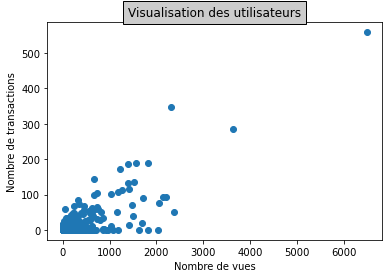

In [9]:
plt.scatter(df_id['Nombre de vues'],df_id['Nombre de transactions'])
plt.xlabel('Nombre de vues')
plt.ylabel('Nombre de transactions')
plt.title('Visualisation des utilisateurs', bbox={'facecolor':'0.8', 'pad':5})
plt.show()

_On observe que la majorité des utilisateurs ont consulté et acheté des produits de manière raisonable, cependant certains d'entre eux ont réalisé plus d'une centaine d'achats en 4 mois et ont consulté le site de manière trop fréquente pour un utilisateur lambda._

* L'objectif du clustering va être de repérer ces utilisateurs anormaux avec un diagramme en boîte (boxplot) de tous les variables explicatives

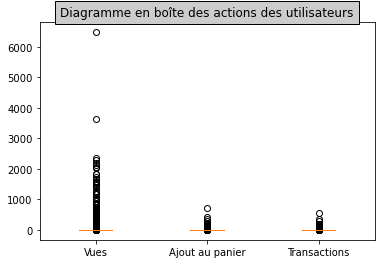

In [10]:
liste = [df_id["Nombre de vues"],df_id["Nombre d'ajout au panier"], df_id["Nombre de transactions"] ]
plt.figure()
plt.title('Diagramme en boîte des actions des utilisateurs', bbox={'facecolor':'0.8', 'pad':5})
plt.boxplot(liste, labels = ['Vues', 'Ajout au panier', "Transactions"])
plt.show()

_On observe égalememt sur ce diagramme en boîte des utilisateurs ayant des statistiques de visualisation ou d'achat qui sortent de l'ordinaire._

* On réalise la méthode du coude afin de déterminer le juste nombre de clusters nécessaire :

In [11]:
# Liste des nombres de clusters
range_n_clusters = [2, 3, 4, 5, 6]  

# Initialisation de la liste de distorsions
distorsions = []

# Calcul des distorsions pour les différents modèles
for n_clusters in range_n_clusters:
    
    # Initialisation d'un cluster ayant un pour nombre de clusters n_clusters
    cluster = KMeans(n_clusters = n_clusters)
    
    # Apprentissage des données suivant le cluster construit ci-dessus
    cluster.fit(df_id)
    
    # Ajout de la nouvelle distorsion à la liste des données
    distorsions.append(sum(np.min(cdist(df_id, cluster.cluster_centers_, 'euclidean'), axis=1)) / np.size(df_id, axis = 0))

* Puis on visualise les distorsions en fonction du nombre de clusters

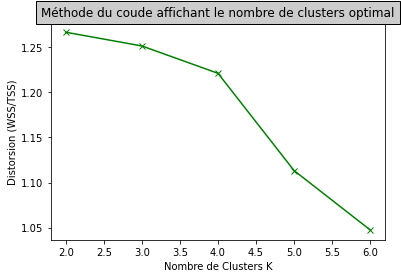

In [12]:
plt.plot(range_n_clusters, distorsions, 'gx-')
plt.xlabel('Nombre de Clusters K')
plt.ylabel('Distorsion (WSS/TSS)')
plt.title('Méthode du coude affichant le nombre de clusters optimal', bbox={'facecolor':'0.8', 'pad':5})
plt.show()

* Mise en place de l'algorithme des K-means avec 4 clusters (choisis grâce a la méthode du coude vue précédemment)

In [13]:
# k-means
kmeans = KMeans(n_clusters=4, random_state=0)
df_id["cluster"] = kmeans.fit_predict(df_id[['Nombre de vues', 'Nombre de transactions']])

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to df
df_id['cen_x'] = df_id.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2],3:cen_x[3]})
df_id['cen_y'] = df_id.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2],3:cen_y[3]})

# define and map colors
colors = ['#bf20df', '#2095DF',"#AE6042", '#DF2020']
df_id['c'] = df_id.cluster.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3]})

* Visualisation du k-mean

Text(0, 0.5, 'Nombre de transactions')

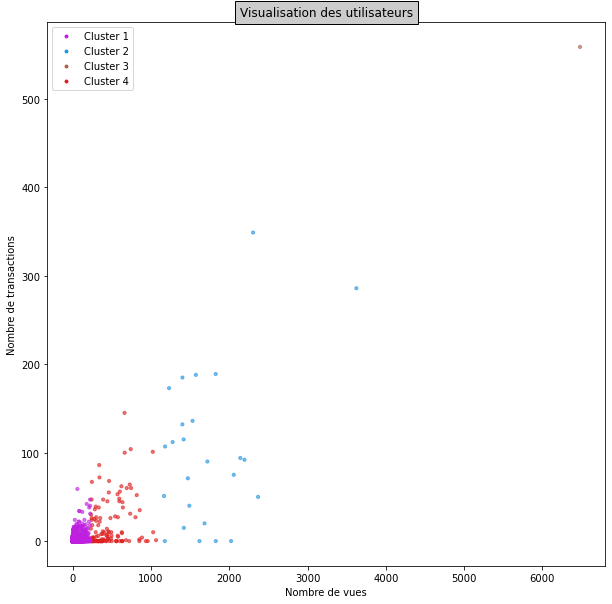

In [14]:
#Visualisation
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1, figsize=(10,10))

# plot des data
plt.scatter(df_id['Nombre de vues'], df_id['Nombre de transactions'], c= df_id.c, alpha = 0.6, s=10)

# Legende
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]

# plot de la legende
plt.legend(handles=legend_elements, loc='upper left')

# titre et labels
plt.title("Visualisation des utilisateurs", bbox={'facecolor':'0.8', 'pad':5})
plt.xlabel('Nombre de vues')
plt.ylabel('Nombre de transactions')

Grâce au clustering on observe 4 clusters distincts qui nous permettent d'isoler les utilisateurs ayant un comportement anormal.
On peut émettre alors plusieurs hypothèses sur les utilisateurs présents dans le 3ème et 4ème clusters :
- Il y a un bug et plusieurs clients utilisent le site avec le même id uilisateur.
- Certains utilisateurs sont des clients b2b et font de très grosses commandes sur le site.
- Certains utilisateurs sont en réalité des bots.

**AJOUT DU 16/04 :**


Cette partie a pour objectif de créer des dataframes qui montrent les produits achetés, ajoutés au panier ou vu par les utilisateurs groupés par cluster.
Pour commencer on crée un dataframe qui reprend certaines données de df_id : le cluster de chaque utilisateur avec tous les évènements qui le concernent.

In [15]:
df_id_cluster = df_id[['cluster','Nombre de transactions','Nombre d\'ajout au panier','Nombre de vues']]
df_id_cluster

,cluster,Nombre de transactions,Nombre d'ajout au panier,Nombre de vues
visitorid,,,,
1150086,2,559.0,719.0,6479.0
530559,1,286.0,419.0,3623.0
895999,1,50.0,56.0,2368.0
152963,1,349.0,371.0,2304.0
163561,1,92.0,124.0,2194.0
...,...,...,...,...
409939,0,1.0,0.0,0.0
684791,0,1.0,0.0,0.0
1246009,0,1.0,0.0,0.0


* On cherche à identifier le nombre de visiteurs qui correspondent à chaque cluster :

_On observe une grande disproportion de visiteurs entre les clusters. Les clusters 1, 2 et 3 présentent des utilisateurs aux comprtements extrêmes et qu'il faudra traiter séparemment (traitement business, recherche d'un bug technique…étude à approfondir)._

In [16]:
vuesdf = df_id_cluster.index[df_id['Nombre de vues'] == 0].nunique()
print(vuesdf, ' visiteurs, tous clusters confondus, sont venus sur le site sans regarder un seul item')

panierdf = df_id_cluster.index[df_id['Nombre d\'ajout au panier'] == 0].nunique()
print(panierdf, ' visiteurs, tous clusters confondus, sont venus sur le site sans ajouter au panier un seul item')

transacdf = df_id_cluster.index[df_id['Nombre de transactions'] == 0].nunique()
print(transacdf, ' visiteurs, tous clusters confondus, sont venus sur le site sans acheter un seul item')

3401  visiteurs, tous clusters confondus, sont venus sur le site sans regarder un seul item
1369858  visiteurs, tous clusters confondus, sont venus sur le site sans ajouter au panier un seul item
1395861  visiteurs, tous clusters confondus, sont venus sur le site sans acheter un seul item


* Il est intéressant de visualiser par cluster le nombre de vues, d'ajouts au panier et de transactions :

In [17]:
df_nb_views_cluster = df_id_cluster.groupby('cluster').sum()
df_nb_views_cluster.head()

,Nombre de transactions,Nombre d'ajout au panier,Nombre de vues
cluster,,,
0,17063.0,61719.0,2556820.0
1,2570.0,3342.0,43122.0
2,559.0,719.0,6479.0
3,2265.0,3552.0,57891.0


_Au regard du nombre de vues conséquent sur le cluster 0, il sera intéressant de le séparer en sous-clusters pour étudier la population de visiteurs plus finement. Ce qu'on fera ultérieurement._

* on créer un nouveau dataframe qui permet de lier les informations que l'on a sur chaque visiteur selon son cluster d'appartenance mais en y ajoutant l'itemid. Cela nous permet de voir quels produits ont été visités par visiteur.

In [18]:
df_linked = df_events.merge(right  = df_id_cluster, on = 'visitorid', how = 'inner')
df_linked.head()

,timestamp,visitorid,event,itemid,transactionid,day_of_week,events_addtocart,events_transaction,events_view,cluster,Nombre de transactions,Nombre d'ajout au panier,Nombre de vues
0,2015-06-02 00:02:12.117,257597,view,355908,NaN,Tuesday,0,0,1,0,0.0,0.0,2.0
1,2015-06-08 17:00:21.247,257597,view,302696,NaN,Monday,0,0,1,0,0.0,0.0,2.0
2,2015-06-02 00:50:14.164,992329,view,248676,NaN,Tuesday,0,0,1,0,0.0,0.0,30.0
3,2015-06-02 00:57:52.007,992329,view,193150,NaN,Tuesday,0,0,1,0,0.0,0.0,30.0
4,2015-06-02 01:12:35.976,992329,view,246453,NaN,Tuesday,0,0,1,0,0.0,0.0,30.0


* Le dataframe suivant représente le nombre total d'événements en fonction des clusters et de chaque produit :

In [19]:
df_table = pd.crosstab(df_linked["itemid"],df_linked["cluster"])
sum_column = df_table[1] + df_table[2] + df_table[3] + df_table[0]
df_table['Total'] = sum_column
df_table = df_table.sort_values(by = 'Total', ascending = False)
df_table

cluster,0,1,2,3,Total
itemid,,,,,
187946,3411,0,0,1,3412
461686,2810,61,29,78,2978
5411,2320,4,0,10,2334
370653,1853,0,0,1,1854
219512,1736,30,11,23,1800
...,...,...,...,...,...
356847,1,0,0,0,1
356844,1,0,0,0,1
356843,1,0,0,0,1


* Les dataframes suivants suivent les mêmes principes mais cette fois-ci en fonction du type d'événement : vue, ajout au panier et transaction :

In [20]:
df_view = df_linked[df_linked['event'] != 'transactions']
df_view = df_view[df_view['event'] != 'addtocart']

table_view = pd.crosstab(df_view["itemid"],df_view["cluster"])
sum_column = table_view[1] + table_view[2] + table_view[3] + table_view[0]
table_view['Total'] = sum_column
table_view = table_view.sort_values(by = 'Total', ascending = False)
table_view

cluster,0,1,2,3,Total
itemid,,,,,
187946,3409,0,0,1,3410
461686,2514,58,25,75,2672
5411,2312,4,0,9,2325
370653,1853,0,0,1,1854
219512,1691,28,10,23,1752
...,...,...,...,...,...
154410,1,0,0,0,1
71262,1,0,0,0,1
309388,1,0,0,0,1


In [21]:
df_addtocart = df_linked[df_linked['event'] != 'view']
df_addtocart = df_addtocart[df_addtocart['event'] != 'transactions']

table_addtocart = pd.crosstab(df_addtocart["itemid"],df_addtocart["cluster"])
sum_column = table_addtocart[1] + table_addtocart[2] + table_addtocart[3] + table_addtocart[0]
table_addtocart['Total'] = sum_column
table_addtocart = table_addtocart.sort_values(by = 'Total', ascending = False)
table_addtocart

cluster,0,1,2,3,Total
itemid,,,,,
461686,421,6,6,6,439
312728,172,4,0,32,208
409804,166,10,2,13,191
320130,151,8,2,13,174
29196,123,0,2,30,155
...,...,...,...,...,...
284252,1,0,0,0,1
284259,1,0,0,0,1
284265,1,0,0,0,1


In [22]:
df_transaction = df_linked[df_linked['event'] != 'view']
df_transaction = df_transaction[df_transaction['event'] != 'addtocart']

table_transaction = pd.crosstab(df_transaction ["itemid"],df_transaction ["cluster"])
sum_column = table_transaction[1] + table_transaction[2] + table_transaction[3] + table_transaction[0]

table_transaction['Total'] = sum_column
table_transaction = table_transaction.sort_values(by = 'Total', ascending = False)
table_transaction

cluster,0,1,2,3,Total
itemid,,,,,
461686,125,3,2,3,133
119736,14,45,1,37,97
213834,65,11,2,14,92
312728,38,0,0,8,46
7943,41,0,1,4,46
...,...,...,...,...,...
190034,1,0,0,0,1
190095,1,0,0,0,1
190243,1,0,0,0,1


_Afin d'augmenter la précision de nos analyses, nous allons nous concentrer sur le cluster 0 qui concentre 99.98% des utilisateurs._

* Pour cela nous allons faire une étude spécifiquement sur les utilisateurs du cluster 0. Création d'un nouveau dataframe contenant les utilisateurs du cluster 0 :

In [23]:
df_new = df_id[df_id.cluster == 0]
df_new = df_new.drop(['cluster', 'cen_x', "cen_y", "c"], axis=1)
df_new.head()

,Nombre de vues,Nombre d'ajout au panier,Nombre de transactions
visitorid,,,
317355,228.0,5.0,0.0
1035814,224.0,42.0,31.0
438441,222.0,42.0,47.0
797409,221.0,48.0,40.0
1381830,221.0,6.0,2.0


* On réalise à nouveau la méthode du coude afin de déterminer le juste nombre de clusters nécessaires :

In [24]:
# Liste des nombre de clusters
range_n_clusters = [2, 3, 4, 5, 6]  

# Initialisation de la liste de dissortions
distorsions = []

# Calcul des distorsions pour les différents modèles
for n_clusters in range_n_clusters:
    
    # Initialisation d'un cluster ayant un pour nombre de clusters n_clusters
    cluster = KMeans(n_clusters = n_clusters)
    
    # Apprentissage des données suivant le cluster construit ci-dessus
    cluster.fit(df_new)
    
    # Ajout de la nouvelle distorsion à la liste des données
    distorsions.append(sum(np.min(cdist(df_new, cluster.cluster_centers_, 'euclidean'), axis=1)) / np.size(df_id, axis = 0))

* Puis on visualise les distorsions en fonction du nombre de clusters :

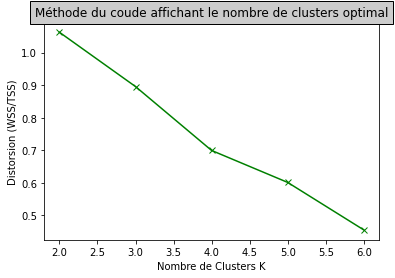

In [25]:
plt.plot(range_n_clusters, distorsions, 'gx-')
plt.xlabel('Nombre de Clusters K')
plt.ylabel('Distorsion (WSS/TSS)')
plt.title('Méthode du coude affichant le nombre de clusters optimal', bbox={'facecolor':'0.8', 'pad':5})
plt.show()

* Mise en place de l'algorithme des K-means avec 4 clusters (choisis grâce a la méthode du coude vue précédemment)

In [26]:
# k-means
kmeans = KMeans(n_clusters=4, random_state=0)
df_new["cluster"] = kmeans.fit_predict(df_new[['Nombre de vues', 'Nombre de transactions']])

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to df
df_new['cen_x'] = df_id.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2],3:cen_x[3]})
df_new['cen_y'] = df_id.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2],3:cen_y[3]})

# define and map colors
colors = ['#bf20df', '#2095DF',"#AE6042", '#DF2020']
df_new['c'] = df_new.cluster.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3]})

* Visualisation des nouveaux clusters créés a partir du cluster 0 :

Text(0, 0.5, 'Nombre de transactions')

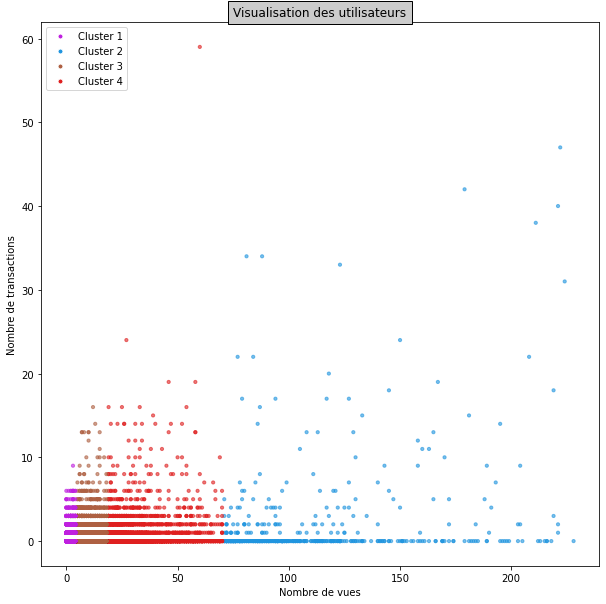

In [27]:
#Visualisation
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1, figsize=(10,10))

# plot des data
plt.scatter(df_new['Nombre de vues'], df_new['Nombre de transactions'], c= df_new.c, alpha = 0.6, s=10)

# Legende
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]

# plot de la legende
plt.legend(handles=legend_elements, loc='upper left')

# titre et labels
plt.title("Visualisation des utilisateurs", bbox={'facecolor':'0.8', 'pad':5})
plt.xlabel('Nombre de vues')
plt.ylabel('Nombre de transactions')

In [28]:
df_new.cluster.value_counts()

0    1331406
2      69715
3       5843
1        464
Name: cluster, dtype: int64

_On observe une distribution beaucoup plus homogène entre les clusters.
Cette distribution va nous permetre d'établir une segmentation plus précise, et d'augmenter la précision de notre algorithme de machine learning._

**Par ces constats, visualisations et travaux de clustering réalisés, on souhaite prédire ce qu'un visiteur sera susceptible d'acheter, selon son ou ses précédents achats, afin de lui proposer des articles en lien avec ses intérêts et maximiser le taux de transformation : moteur de recommandation.**

**Cédric, AJOUT 20/04**

• Dans une nouvelle variable cluster_0_classe, découpe des transactions de df_new en 4 classes distinctes avec pour labels 0, 1, 2, 3 selon les 3 quantiles de la nouvelle variable crée.

In [29]:
# Firstly let's create an array that lists visitors who made a purchase
customer_purchased = df_events[df_events.transactionid.notnull()].visitorid.unique()
    
purchased_items = []
buyer = []
    
# Create another list that contains all their purchases 
for customer in customer_purchased:

    #Generate a Pandas series type object containing all the visitor's purchases and put them in the list
    buyer.append(customer)
    purchased_items.append(list(df_events.loc[(df_events.visitorid == customer) & (df_events.transactionid.notnull())].itemid.values))

In [30]:
purchased_items_df = pd.DataFrame({"Purchased_items":purchased_items})
purchased_items_df.head()


,Purchased_items
0,[356475]
1,"[15335, 380775, 237753, 317178, 12836, 400969,..."
2,[81345]
3,"[150318, 49521]"
4,"[310791, 299044]"


In [31]:
data = pd.DataFrame({"Buyer":buyer, "Purchased_items":purchased_items})
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11719 entries, 0 to 11718
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Buyer            11719 non-null  int64 
 1   Purchased_items  11719 non-null  object
dtypes: int64(1), object(1)
memory usage: 183.2+ KB


Quelles ont nos variables explicatives ? TEST DA121

• Stockez dans une variable data, les données explicatives uniquement.

• Séparez les données en un ensemble d'apprentissage et un ensemble de test (20%), avec data comme données explicatives et charges_classes comme variable cible.

• Centrer et réduire les variables explicatives des deux échantillons de manière adéquate.



Dans la suite nous allons comparer plusieurs méthodes d'apprentissage. Pour chacune d'elles, il conviendra d'explorer le périmètre des hyperparamètres suivant :

K-plus proches voisins. Hyperparamètre à régler :

'n_neighbors' : 2 à 50.
SVM. Hyperparamètres à régler :

kernel : 'rbf', 'linear'.
C : 0.1 ; 1 ; 10 ; 50 .
RandomForest. Hyperparamètres à régler :

'max_features': "sqrt", "log2", None
'min_samples_split': Nombres pairs allant de 2 à 30.
Pour chaque algorithme mentionné ci-dessus:

Sélectionnez les hyperparamètres sur l'échantillon d’apprentissage par validation croisée
Affichez les hyperparamètres retenus
Appliquez le modèle à l'ensemble de test, affichez la matrice de confusion et le score du modèle sur ce dernier

Quel modèle fournit la meilleure précision ?